# CLIP GP Classifier for Chest X-Ray Images

This notebook implements a Gaussian Process classifier using CLIP embeddings for chest X-ray image classification.

## Setup and Imports

First, let's install the required packages and import the necessary libraries.

In [ ]:
!pip install torch torchvision gpytorch scikit-learn seaborn tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-f3ymct9y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-f3ymct9y
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import gpytorch
import clip
import os
import numpy as np
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from torch import nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image

# Set up device and random seed
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Download Dataset

Next, we'll download and extract the ChestXRay2017 dataset.

In [ ]:
!if [ ! -f ChestXRay2017.zip ]; then gdown --fuzzy https://drive.google.com/file/d/1jf1XvAeXPD4XAerknz5inxM0StuCNbyX/view?usp=sharing; unzip ChestXRay2017.zip; fi

## Constants and Model Initialization

Now, let's set up our constants and initialize the CLIP model.

In [ ]:
# Constants
data_dir = 'chest_xray'
batch_size = 4
num_workers = 4
epoch_num = 100
lr = 1e-4

# Load CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

## Custom Dataset and Data Loaders

We'll create a custom dataset class and set up our data loaders.

In [ ]:
# Custom dataset to return file paths
class CustomImageDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        return path, target

# Load dataset
image_dataset = CustomImageDataset(os.path.join(data_dir, 'train'))  # Assuming all data is in 'train'
dataset_size = len(image_dataset)
class_names = image_dataset.classes

print(f"Dataset size: {dataset_size}")
print(f"Class names: {class_names}")

Dataset size: 5232
Class names: ['NORMAL', 'PNEUMONIA']


## Embedding Generation

This function generates CLIP embeddings for our images:

In [ ]:
def generate_embeddings(image_paths, model, preprocess):
    all_embeddings = []
    all_labels = []
    all_filenames = []

    model.eval()
    with torch.no_grad():
        for path, label in tqdm(image_paths, desc="Generating embeddings"):
            image = preprocess(Image.open(path)).unsqueeze(0).to(device)
            embedding = model.encode_image(image)

            all_embeddings.append(embedding.cpu().numpy())
            all_labels.append(label)
            all_filenames.append(os.path.relpath(path, data_dir))

    return np.vstack(all_embeddings), np.array(all_labels), np.array(all_filenames)

# Generate embeddings for the entire dataset
print("Generating CLIP embeddings...")
embeddings, labels, filenames = generate_embeddings(image_dataset.samples, clip_model, clip_preprocess)

# Split into training and test sets
X_train, X_test, y_train, y_test, filenames_train, filenames_test = train_test_split(
    embeddings, labels, filenames, test_size=0.2, random_state=42, stratify=labels)

print(f"Training size: {len(y_train)}, Test size: {len(y_test)}")

Generating CLIP embeddings...


Generating embeddings: 100%|██████████| 5232/5232 [01:57<00:00, 44.66it/s]

Training size: 4185, Test size: 1047


## GP Model Definition

Here's our Gaussian Process model definition:

In [ ]:
class GPClassificationModel(gpytorch.models.AbstractVariationalGP):
    def __init__(self, num_features):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=500)
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, torch.randn(500, num_features), variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize models
gp_model = GPClassificationModel(num_features=512).to(device)  # CLIP ViT-B/32 outputs 512-dimensional features
likelihood = gpytorch.likelihoods.BernoulliLikelihood().to(device)

## Training Function

Here's our main training function:

In [ ]:
def train_model(clip_model, gp_model, likelihood, optimizer, scheduler, num_epochs, X_train, y_train):
    best_model_wts = {
        'gp_model': copy.deepcopy(gp_model.state_dict()),
        'likelihood': copy.deepcopy(likelihood.state_dict())
    }
    best_acc = 0.0

    mll = gpytorch.mlls.VariationalELBO(likelihood, gp_model, num_data=len(y_train))

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        gp_model.train()
        likelihood.train()

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        # Convert to tensors
        embeddings = torch.tensor(X_train).to(device)
        labels = torch.tensor(y_train).to(device).float()

        # Process in batches
        for i in range(0, len(embeddings), batch_size):
            batch_embeddings = embeddings[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            optimizer.zero_grad()

            outputs = gp_model(batch_embeddings)
            loss = -mll(outputs, batch_labels)

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                pred_probs = likelihood(outputs).probs
                preds = (pred_probs > 0.5).float().squeeze()

            running_loss += loss.item() * batch_embeddings.size(0)
            running_corrects += torch.sum(preds == batch_labels.data)
            total_samples += batch_embeddings.size(0)

        scheduler.step()

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        print(f'Train Loss: {epoch_loss:.4f}')# Acc: {epoch_acc:.4f}')

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = {
                'gp_model': copy.deepcopy(gp_model.state_dict()),
                'likelihood': copy.deepcopy(likelihood.state_dict())
            }

    print(f'Best Train Acc: {best_acc:.4f}')

    # Load best model weights
    gp_model.load_state_dict(best_model_wts['gp_model'])
    likelihood.load_state_dict(best_model_wts['likelihood'])

    return gp_model, likelihood

## Evaluation Function

This function evaluates our trained model:

In [ ]:
def evaluate_model(gp_model, likelihood, X_test, y_test):
    gp_model.eval()
    likelihood.eval()

    embeddings = torch.tensor(X_test).to(device)
    labels = torch.tensor(y_test).to(device).float()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    uncertainties = []

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        for i in range(0, len(embeddings), batch_size):
            batch_embeddings = embeddings[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]

            output = gp_model(batch_embeddings)
            predictions = likelihood(output)

            probs = predictions.probs
            preds = (probs > 0.5).float()
            correct += (preds == batch_labels).sum().item()
            total += batch_labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            # Adjust the entropy calculation to work with 1D probabilities
            entropy = - (probs * torch.log(probs + 1e-10) + (1 - probs) * torch.log(1 - probs + 1e-10))
            uncertainties.extend(entropy.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')
    return all_preds, all_labels, uncertainties, probs

## Training and Evaluation

Now, let's train and evaluate our model:

In [ ]:
# Set up optimizer and scheduler
optimizer = optim.AdamW([
    {'params': gp_model.parameters(), 'lr': lr},
    {'params': likelihood.parameters(), 'lr': lr}
], weight_decay=1e-2)  # You can adjust the weight decay value as needed

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train the model
gp_model, likelihood = train_model(clip_model, gp_model, likelihood, optimizer, scheduler, num_epochs=epoch_num,
                                   X_train=X_train, y_train=y_train)

Epoch 1/100
----------
Train Loss: 0.8850
Epoch 2/100
----------
Train Loss: 0.8434
Epoch 3/100
----------
Train Loss: 0.8080
Epoch 4/100
----------
Train Loss: 0.7778
Epoch 5/100
----------
Train Loss: 0.7520
Epoch 6/100
----------
Train Loss: 0.7301
Epoch 7/100
----------
Train Loss: 0.7115
Epoch 8/100
----------
Train Loss: 0.6957
Epoch 9/100
----------
Train Loss: 0.6823
Epoch 10/100
----------
Train Loss: 0.6707
Epoch 11/100
----------
Train Loss: 0.6649
Epoch 12/100
----------
Train Loss: 0.6639
Epoch 13/100
----------
Train Loss: 0.6629
Epoch 14/100
----------
Train Loss: 0.6619
Epoch 15/100
----------
Train Loss: 0.6609
Epoch 16/100
----------
Train Loss: 0.6600
Epoch 17/100
----------
Train Loss: 0.6590
Epoch 18/100
----------
Train Loss: 0.6581
Epoch 19/100
----------
Train Loss: 0.6571
Epoch 20/100
----------
Train Loss: 0.6562
Epoch 21/100
----------
Train Loss: 0.6557
Epoch 22/100
----------
Train Loss: 0.6556
Epoch 23/100
----------
Train Loss: 0.6555
Epoch 24/100
-------

In [ ]:
# Evaluate the model
predictions, true_labels, uncertainties, probs = evaluate_model(gp_model, likelihood, X_train, y_train)

Test Accuracy: 0.7422


## Visualization

Finally, let's visualize our results:

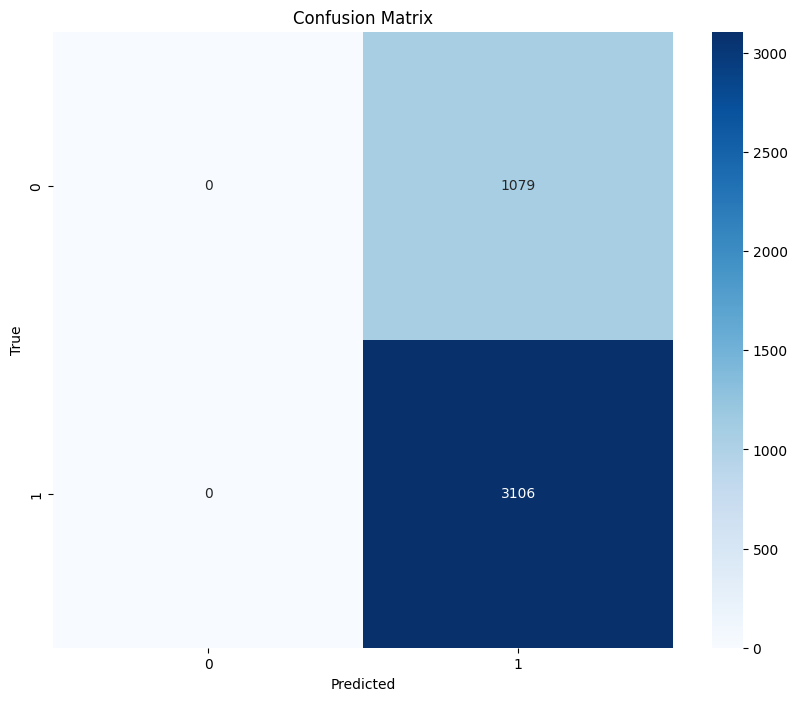

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

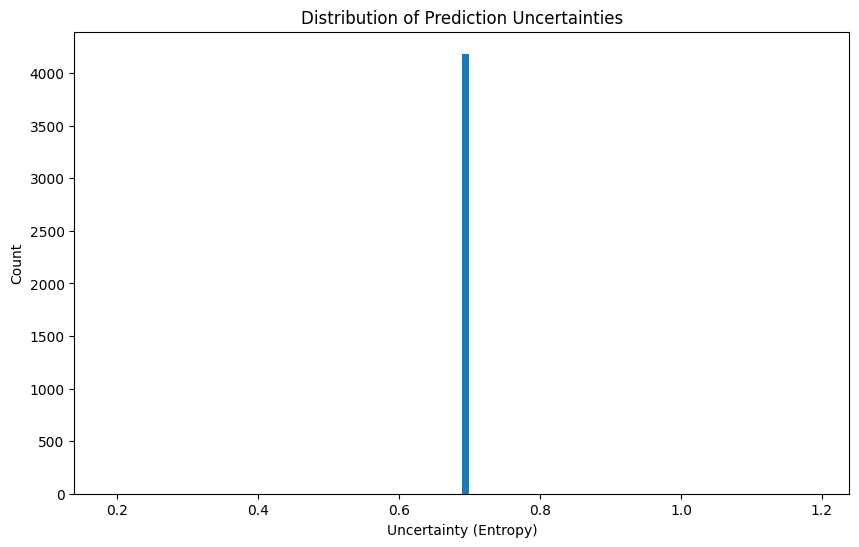

In [ ]:
# Plot uncertainty distribution
plt.figure(figsize=(10, 6))
plt.hist(uncertainties, bins=100)
plt.title('Distribution of Prediction Uncertainties')
plt.xlabel('Uncertainty (Entropy)')
plt.ylabel('Count')
plt.show()